<a href="https://colab.research.google.com/github/Nayoung-young/prj-game-abtesting/blob/main/cookie_cats_abtesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
# Base
# -----------------------------------
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.style.use('seaborn')
sns.set(font_scale = 1.5)
sns.set_style ("whitegrid")

# import missingno as msno # null data를 쉽게 보여주는 라이브러리 

# import warnings 
import warnings 
warnings.filterwarnings('ignore')


%matplotlib inline 
# 한 셀에서 그래프 보여주기 


# Hypothesis Testing
# -----------------------------------
from scipy.stats import shapiro
import scipy.stats as stats

# _1. 데이터 불러오기 

In [2]:
df = pd.read_csv('cookie_cats.csv')
df_base = df.copy()

In [3]:
df_base.info() # 결측치 없음 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [4]:
df_base.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [5]:
df_base['version'].unique().tolist()

['gate_30', 'gate_40']

In [6]:
df_base['userid'].nunique() # userid - unique 

90189

#_1. 프로젝트 설명 
- 출처: https://www.datacamp.com/projects/184 

[ 가설 ] 
`level 30에서 보여줄 때보다 level 40에서 구매유도를 할 경우 7일 리텐션이 더 높다 `
- 성공지표: retention_7 
- 보조지표: retention_1, max_gameround 

- Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment.
- It's a classic "connect three" style puzzle game where the player must connect tiles of the same color in order to clear the board and win the level
- It also features singing cats. 

- As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. 
- In this project, we will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. 

**In particular, we will analyze the impact on player retention.**

# _2. 데이터 살펴보기 
- 결측치 없음 
- 중복데이터 없음 (userid 모두 고유값) 
- outlier 확인 필요 

In [7]:
df_base.columns

Index(['userid', 'version', 'sum_gamerounds', 'retention_1', 'retention_7'], dtype='object')

In [8]:
df_base["sum_gamerounds"].describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

In [9]:
df_base[['version', "sum_gamerounds"]].groupby(['version']).agg(["count", "median", "mean", "std", "max"])

sum_gamerounds                                     
                 count median       mean         std    max
version                                                    
gate_30          44700   17.0  52.456264  256.716423  49854
gate_40          45489   16.0  51.298776  103.294416   2640

In [10]:
# df = df.astype({'시가':'int'})

df_base = df_base.astype({'userid':'str'})
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  object
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(1), object(2)
memory usage: 2.2+ MB


In [11]:
df_base.rename(columns={"sum_gamerounds": "max_gameround"}, inplace=True)

In [12]:
# gate에 따라 그룹 나누기 
df_30 = df_base[ df_base['version'] == 'gate_30' ]
df_40 = df_base[ df_base['version'] == 'gate_40' ]

## 2.1 Outlier 제거 전  

gamerounds - Before Removing The Extreme Value


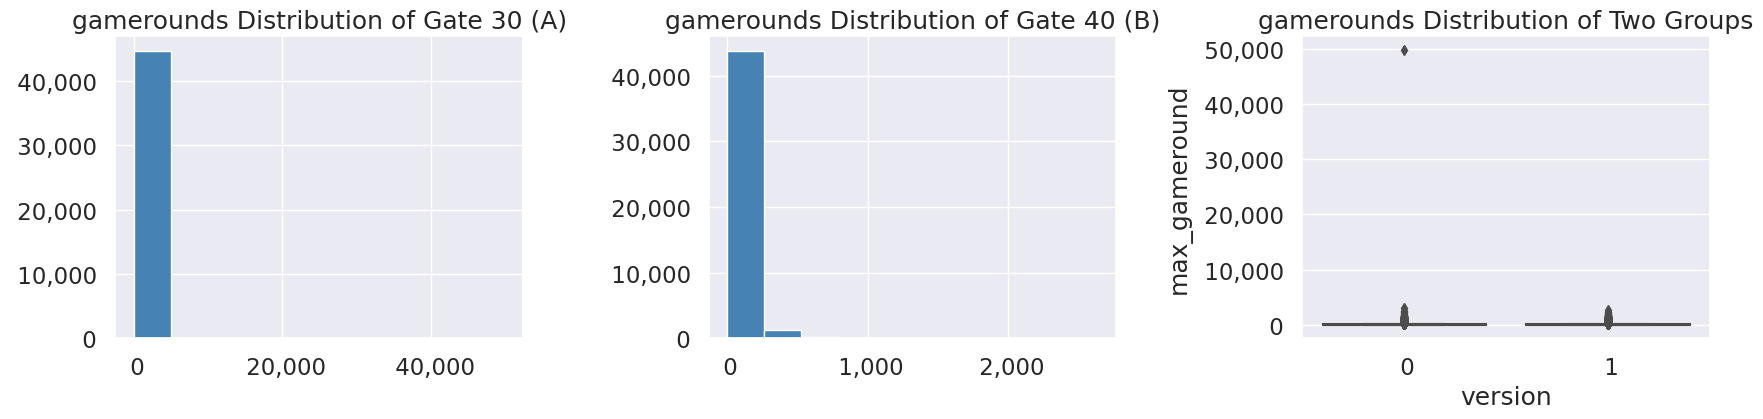

In [13]:
f, ax = plt.subplots(1, 3, figsize = (18,5))

df_30.hist("max_gameround", ax = ax[0], color = "steelblue")
df_40.hist("max_gameround", ax = ax[1], color = "steelblue")
sns.boxplot(x = df_base.version, y = df_base.max_gameround, ax = ax[2])

ax[0].get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x: 0,.0f}')) 
ax[1].get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x: 0,.0f}')) 
ax[2].get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x: 0,.0f}')) 
ax[0].get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x: 0,.0f}')) 
ax[1].get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x: 0,.0f}')) 
ax[2].get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x: 0,.0f}')) 


ax[0].set_title("gamerounds Distribution of Gate 30 (A)")
ax[1].set_title("gamerounds Distribution of Gate 40 (B)")
ax[2].set_title("gamerounds Distribution of Two Groups")

print("gamerounds - Before Removing The Extreme Value")
plt.tight_layout(pad = 2);

gamerounds - Before Removing The Extreme Value


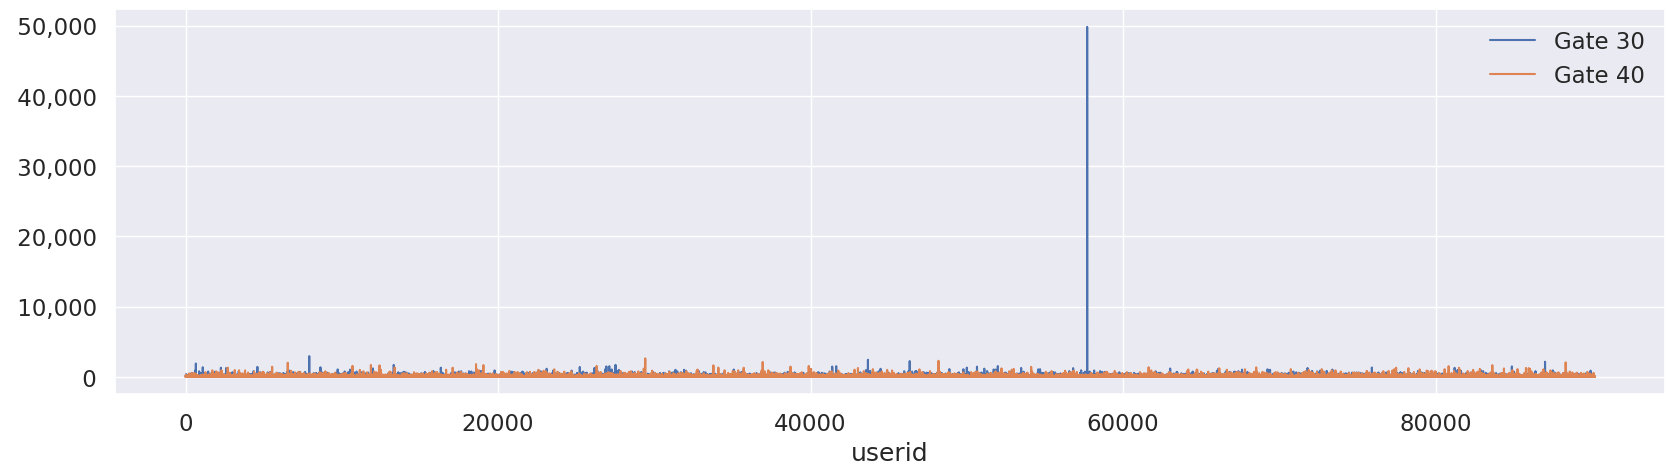

In [14]:
ax = df_30['max_gameround'].plot(legend = True, label = "Gate 30", figsize = (20,5))
ax = df_40['max_gameround'].plot(legend = True, label = "Gate 40", figsize = (20,5))

print('gamerounds - Before Removing The Extreme Value')
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x: 0,.0f}')) 
plt.xlabel('userid'); 

# userid = 50000~ 60000 부근에 outlier가 존재함을 확인 

In [15]:
df_base[df_base['max_gameround'] > 30_000] # outlier 

,userid,version,max_gameround,retention_1,retention_7
57702,6390605,gate_30,49854,False,True


In [16]:
len(df_30)

44700

In [17]:
# outlier 제거 
df_base = df_base[df_base['max_gameround'] < 30_000]

# gate에 따라 그룹 나누기 
df_30 = df_base[ df_base['version'] == 'gate_30' ]
df_40 = df_base[ df_base['version'] == 'gate_40' ]

len(df_30)

44699

## 2.2 Outlier 제거 후 

gamerounds - Before Removing The Extreme Value


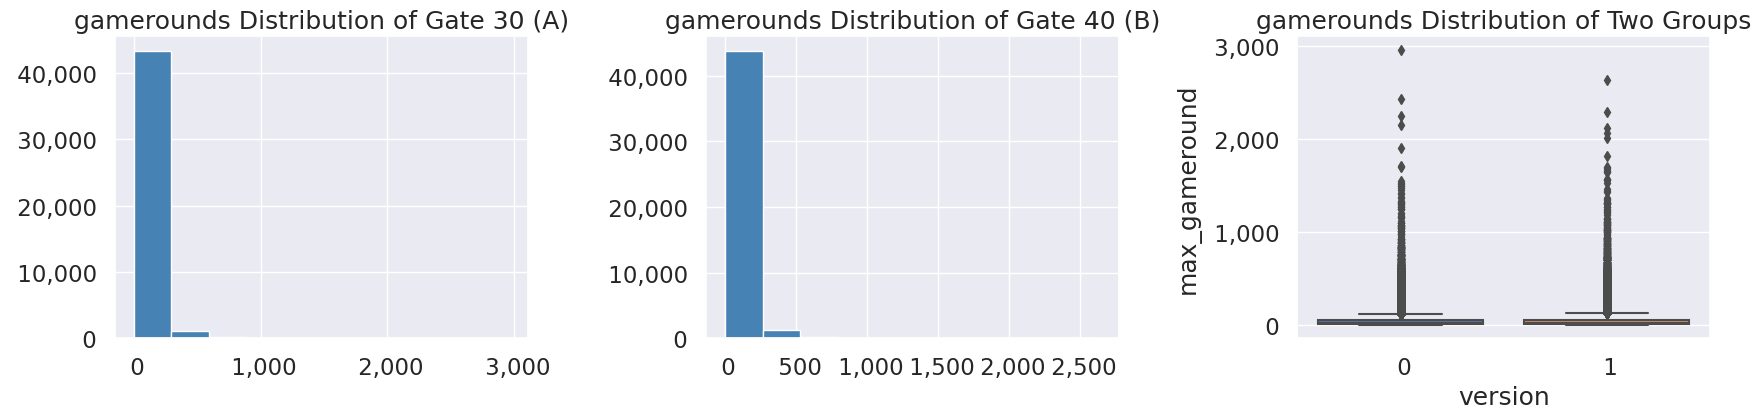

In [18]:
f, ax = plt.subplots(1, 3, figsize = (18,5))

df_30.hist("max_gameround", ax = ax[0], color = "steelblue")
df_40.hist("max_gameround", ax = ax[1], color = "steelblue")
sns.boxplot(x = df_base.version, y = df_base.max_gameround, ax = ax[2])

ax[0].get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x: 0,.0f}')) 
ax[1].get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x: 0,.0f}')) 
ax[2].get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x: 0,.0f}')) 
ax[0].get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x: 0,.0f}')) 
ax[1].get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x: 0,.0f}')) 
ax[2].get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x: 0,.0f}')) 


ax[0].set_title("gamerounds Distribution of Gate 30 (A)")
ax[1].set_title("gamerounds Distribution of Gate 40 (B)")
ax[2].set_title("gamerounds Distribution of Two Groups")

print("gamerounds - Before Removing The Extreme Value")
plt.tight_layout(pad = 2);

gamerounds - Before Removing The Extreme Value


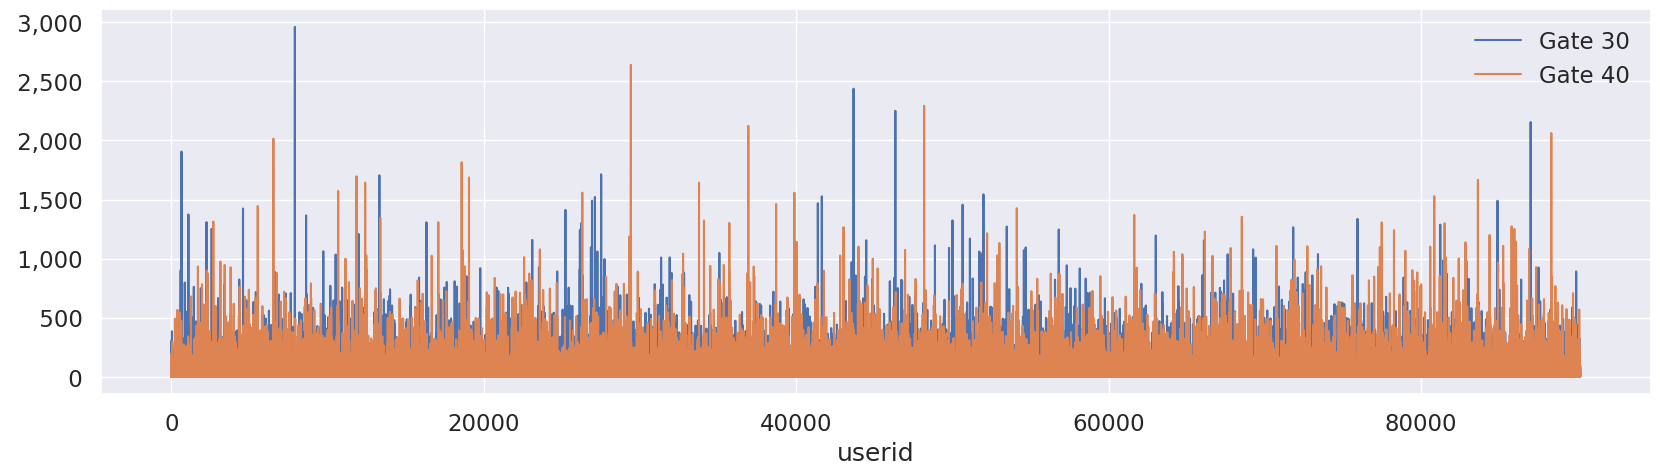

In [19]:
ax = df_30['max_gameround'].plot(legend = True, label = "Gate 30", figsize = (20,5))
ax = df_40['max_gameround'].plot(legend = True, label = "Gate 40", figsize = (20,5))

print('gamerounds - Before Removing The Extreme Value')
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x: 0,.0f}')) 
plt.xlabel('userid'); 

# userid = 50000~ 60000 부근에 outlier가 존재함을 확인 

## 2.3 특이사항(detail) 확인 
- 각 그룹의 유저가 광고가 뜨는 레벨까지 플레이했는지 확인 

In [20]:
len(df_base[df_base['max_gameround'] == 0]) # 게임을 설치했으나 플레이하지 않은 유저들 

3994

In [21]:
df_base[df_base['max_gameround'] == 0].head()

,userid,version,max_gameround,retention_1,retention_7
6,1066,gate_30,0,False,False
11,2101,gate_30,0,False,False
26,3095,gate_30,0,False,False
35,4076,gate_40,0,False,False
37,4176,gate_30,0,False,False


In [22]:
df_base[['userid', 'retention_1']].groupby('retention_1').agg({'userid':'count'}).reset_index()

,retention_1,userid
0,False,50035
1,True,40153


In [23]:
df_base[['userid', 'retention_7']].groupby('retention_7').agg({'userid':'count'}).reset_index()

,retention_7,userid
0,False,73408
1,True,16780


In [24]:
df_base[['userid', 'max_gameround']].groupby(['max_gameround'], as_index=True).agg({'userid': 'count'}) # max_gameround가 커질수록 user count 수는 줄어듦 

,userid
max_gameround,
0,3994
1,5538
2,4606
3,3958
4,3629
...,...
2251,1
2294,1
2438,1


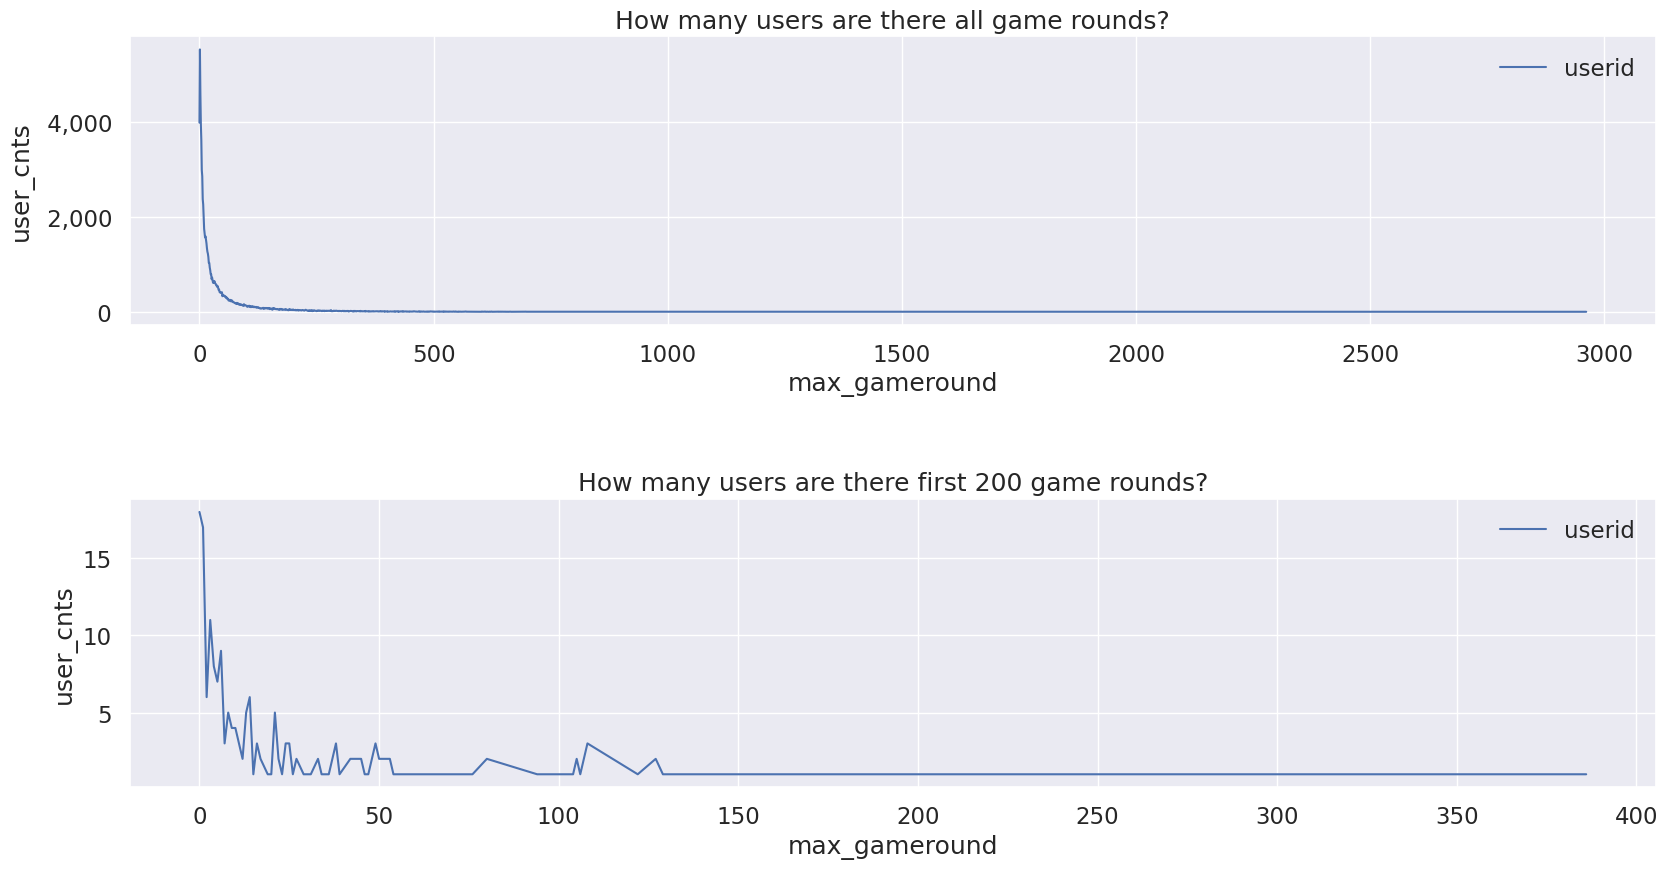

In [25]:
f, ax = plt.subplots(2, 1, figsize = (18, 10))

df_base[['userid', 'max_gameround']].groupby(['max_gameround'], as_index=True).agg(userid = ('userid', 'count')).plot(ax = ax[0])
df_base[['userid', 'max_gameround']][:200].groupby(['max_gameround'], as_index=True).agg(userid = ('userid', 'count')).plot(ax = ax[1])

ax[0].get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x: 0,.0f}')) 

ax[0].set_title("How many users are there all game rounds?")
ax[1].set_title("How many users are there first 200 game rounds?")

ax[0].set_ylabel('user_cnts')
ax[1].set_ylabel('user_cnts')
plt.tight_layout(pad=3);


- gate_30: level = 30에 도달 시 광고창 뜸 
- gate_40: level = 40에 도달 시 광고창 뜸 

**즉, 각 유저가 해당 level의 gameround까지 플레이했는지 확인해야 함!!**

In [26]:
# A group 
print(len(df_30[df_30['max_gameround'] >= 30]))
print(len(df_30[df_30['max_gameround'] < 30]))

df_30['over_level'] = df_30.apply(lambda x: True if x.max_gameround >= 30 else False, axis = 1)
df_30.head()

16655
28044


,userid,version,max_gameround,retention_1,retention_7,over_level
0,116,gate_30,3,False,False,False
1,337,gate_30,38,True,False,True
6,1066,gate_30,0,False,False,False
11,2101,gate_30,0,False,False,False
13,2179,gate_30,39,True,False,True


In [27]:
# B group 
print(len(df_40[df_40['max_gameround'] >= 40]))
print(len(df_40[df_40['max_gameround'] < 40]))

df_40['over_level'] = df_40.apply(lambda x: True if x.max_gameround >= 40 else False, axis = 1)
df_40.head()

13827
31662


,userid,version,max_gameround,retention_1,retention_7,over_level
2,377,gate_40,165,True,False,True
3,483,gate_40,1,False,False,False
4,488,gate_40,179,True,True,True
5,540,gate_40,187,True,True,True
7,1444,gate_40,2,False,False,False


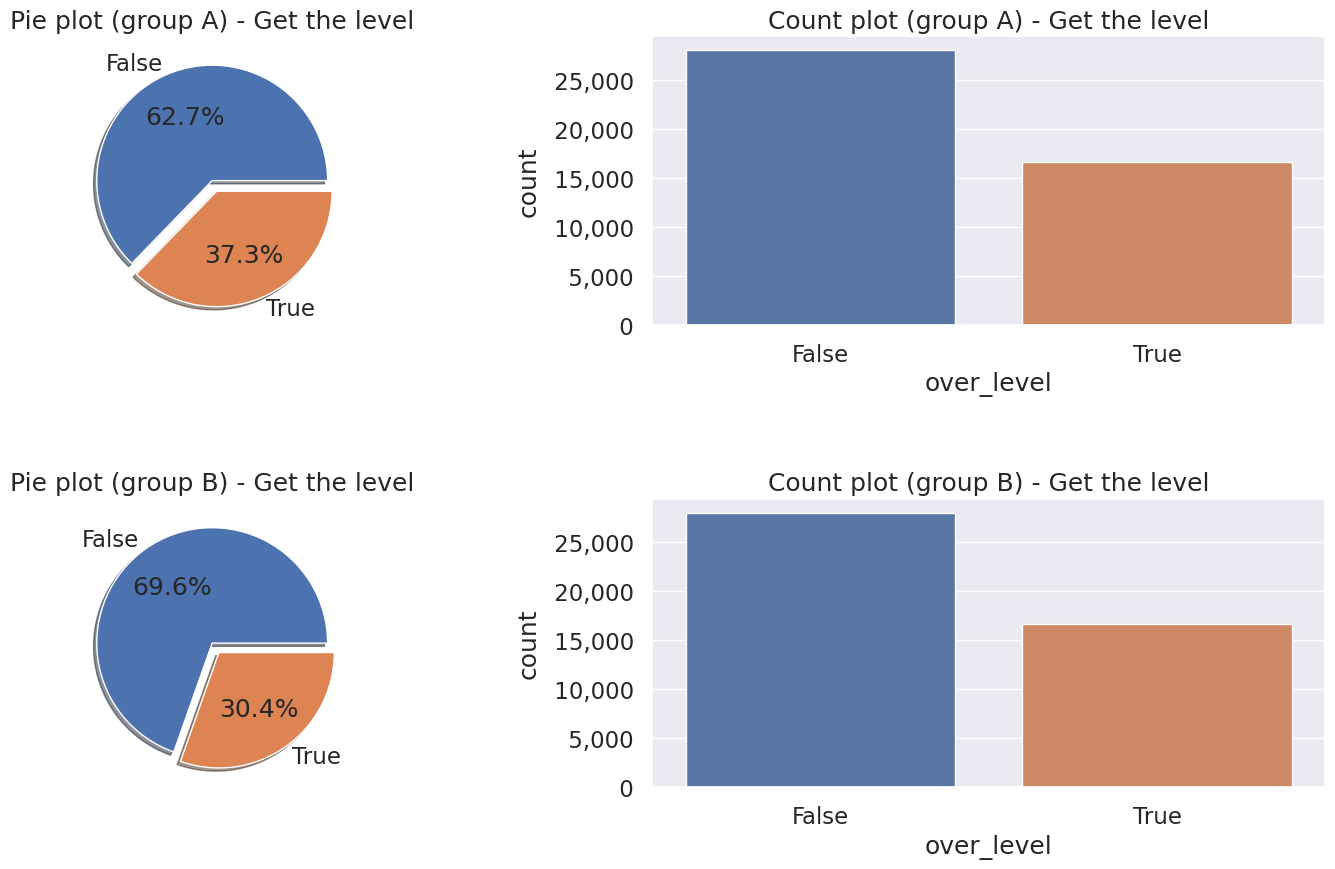

In [28]:
# plotting pie chart 
f, ax = plt.subplots(2, 2, figsize = (16, 10))

df_30['over_level'].value_counts().plot.pie(explode = [0, 0.1], autopct = '%1.1f%%', ax = ax[0][0], shadow = True)
sns.countplot(x = df_30['over_level'], ax = ax[0][1])

df_40['over_level'].value_counts().plot.pie(explode = [0, 0.1], autopct = '%1.1f%%', ax = ax[1][0], shadow = True )
sns.countplot(x = df_30['over_level'], ax = ax[1][1])

# subplot - group 1 
ax[0][0].set_title('Pie plot (group A) - Get the level')
ax[0][0].set_ylabel('')
ax[0][1].set_title('Count plot (group A) - Get the level')
ax[0][1].get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x: 0,.0f}')) 

# subplot - group 2 
ax[1][0].set_title('Pie plot (group B) - Get the level')
ax[1][0].set_ylabel('')
ax[1][1].set_title('Count plot (group B) - Get the level')
ax[1][1].get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x: 0,.0f}')) 

plt.tight_layout(pad=3);

- group A 와 group B의 분포는 어느 정도 비슷해보임 
  - 해당 level에 도달했는지 vs. 안했는지 

In [61]:
# A/B 그룹의 요약 통계량 비교
df_base.groupby('version').max_gameround.agg(['count', 'median', 'mean', 'std', 'max', 'min'])


,count,median,mean,std,max,min
version,,,,,,
gate_30,44699,17.0,51.342111,102.057598,2961,0
gate_40,45489,16.0,51.298776,103.294416,2640,0


##2.4 Retention 확인 

In [63]:
# A/B 그룹의 요약 통계량 비교 - 1 day retention 
df_base.groupby(['version', 'retention_1']).max_gameround.agg(['count', 'median', 'mean', 'std', 'max', 'min'])

count  median       mean         std   max  min
version retention_1                                                 
gate_30 False        24665     6.0  16.359092   36.528426  1072    0
        True         20034    48.0  94.411700  135.037697  2961    0
gate_40 False        25370     6.0  16.340402   35.925756  1241    0
        True         20119    49.0  95.381182  137.887256  2640    0

In [64]:
# A/B 그룹의 요약 통계량 비교 - 7 days retention 
df_base.groupby(['version', 'retention_7']).max_gameround.agg(['count', 'median', 'mean', 'std', 'max', 'min'])

count  median        mean         std   max  min
version retention_7                                                  
gate_30 False        36198    11.0   25.796508   43.316158   981    0
        True          8501   105.0  160.117516  179.358560  2961    0
gate_40 False        37210    11.0   25.856356   44.406112  2640    0
        True          8279   111.0  165.649837  183.792499  2294    0

A/B 그룹의 retention 요약통계량이 비슷해보임 


<Axes: xlabel='retention_1', ylabel='count'>

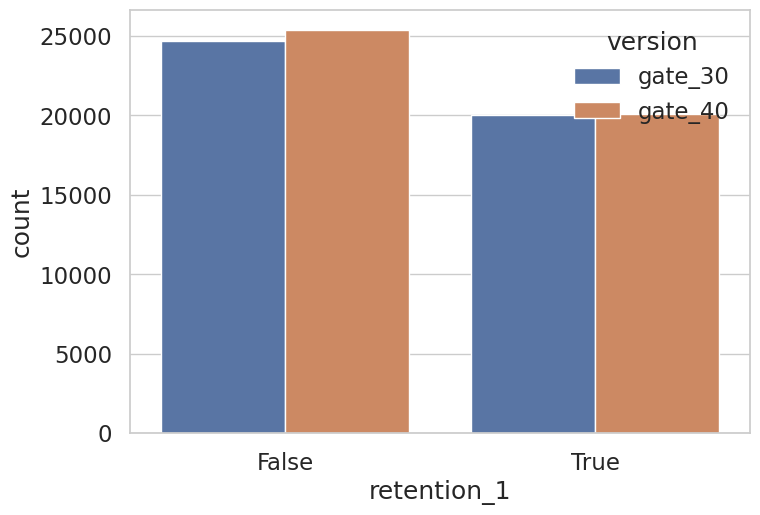

In [77]:
#plot count plot
sns.countplot(data= df_base, x="retention_1", hue="version")

<Axes: xlabel='retention_7', ylabel='count'>

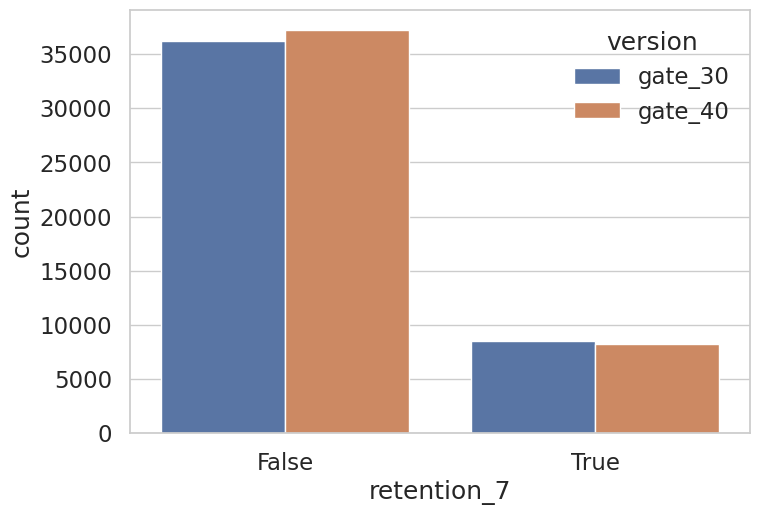

In [78]:
#plot count plot
sns.countplot(data= df_base, x="retention_7", hue="version")

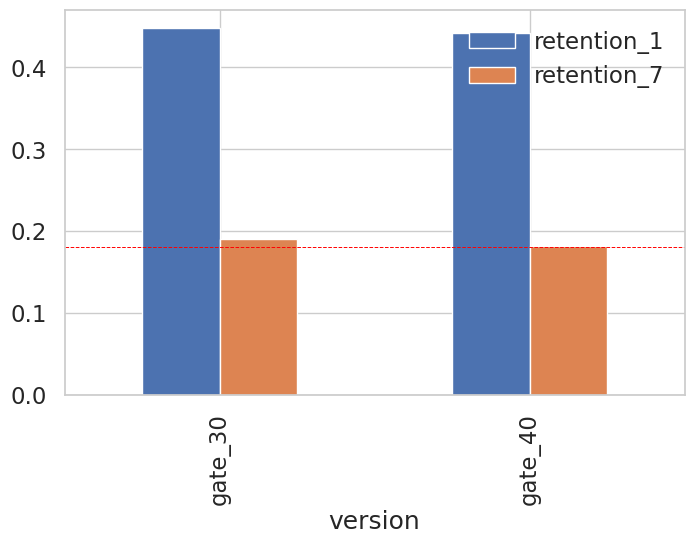

In [79]:
f, ax = plt.subplots(1, 1, figsize = (8, 5))

df_base[['retention_1', 'retention_7', 'version']].groupby(['version'], as_index = True).mean().sort_values(by ='retention_7', ascending = False).plot.bar(ax= ax)
plt.axhline(y = 0.18, color='red', linestyle='--', linewidth= 0.7)


gate_30인 경우가 retention_7이 조금 더 높지만, Hypothesis Testing 결과까지 확인하고 결정하자 

In [73]:
df_base[['retention_1', 'retention_7', 'version']].groupby(['version'], as_index = True).mean()

,retention_1,retention_7
version,,
gate_30,0.448198,0.190183
gate_40,0.442283,0.182000


#_3. A/B Testing 

## 3.1 Hypothesis Testing 

가설: level = 40일 때 유료 결제를 유도하는 창을 띄우는 것이 level = 30일 때 띄우는 것보다 전환율이 높다. 

- A그룹: gate_30, B그룹: gate_40

In [29]:
df_all = pd.concat([df_30, df_40])


In [30]:
df_all['group'] = np.where(df_all.version == 'gate_30', 'A', 'B')
df_all.head()

,userid,version,max_gameround,retention_1,retention_7,over_level,group
0,116,gate_30,3,False,False,False,A
1,337,gate_30,38,True,False,True,A
6,1066,gate_30,0,False,False,False,A
11,2101,gate_30,0,False,False,False,A
13,2179,gate_30,39,True,False,True,A


In [31]:
# Packages
from scipy.stats import shapiro
import scipy.stats as stats

In [32]:
# A/B test Assumptions 

# 1) Normality  : Shapiro Test 
# 2) Homogenity : Levene Test 

# If Parametric + homogenity -> T-Test 
# If Parametric - homogenity -> Welch Test 
# If Non-parametric -> Mann Whitney U Test 


참고: 
- Non-parametric vs Parametric: 
  - https://www.youtube.com/watch?v=ftnOBcXtBEQ
  - https://www.youtube.com/watch?v=c2R90qwPCcU  


In [33]:
# A/B Testing Function - Quick Solution
def AB_Test(dataframe, group, target):

    alpha_level = 0.05
    # Split A/B
    groupA = dataframe[dataframe[group] == "A"][target]
    groupB = dataframe[dataframe[group] == "B"][target]
    
    # Assumption: Normality
    ntA = shapiro(groupA)[1] < alpha_level
    ntB = shapiro(groupB)[1] < alpha_level
    # H0: Distribution is Normal! - False
    # H1: Distribution is not Normal! - True
    
    if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
        # Parametric Test
        # Assumption: Homogeneity of variances
        leveneTest = stats.levene(groupA, groupB)[1] < alpha_level
        # H0: Homogeneity: False
        # H1: Heterogeneous: True
        
        if leveneTest == False:
            # Homogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            # Heterogeneous
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        # Non-Parametric Test
        ttest = stats.mannwhitneyu(groupA, groupB)[1] 
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True
        
    # Result
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < alpha_level], 
        "p-value":[ttest]
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    
    # Columns
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment"]]
    else:
        temp = temp[["Test Type","AB Hypothesis", "p-value", "Comment"]]
    
    # Print Hypothesis
    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")
    
    return temp
    

In [60]:
# Split A/B
group = 'group'
target = 'max_gameround'
alpha_level = 0.05 

groupA = df_all[df_all[group] == "A"][target]
groupB = df_all[df_all[group] == "B"][target]

# Assumption: Normality
ntA = shapiro(groupA)[1] < alpha_level
ntB = shapiro(groupB)[1] < alpha_level

print(ntA)
print(ntB)

True
True


In [34]:
# Apply A/B Testing
AB_Test(dataframe = df_all, group = "group", target = "max_gameround")

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Fail to Reject H0,0.050892,A/B groups are similar!


In [43]:
df_all['max_gameround'].max()

2961

In [51]:
# # histogram

# f = sns.histplot(data = df_all, x= 'max_gameround',hue = 'group')
# f.set(ylim = (0, 3000), xlim= (0, 3000))

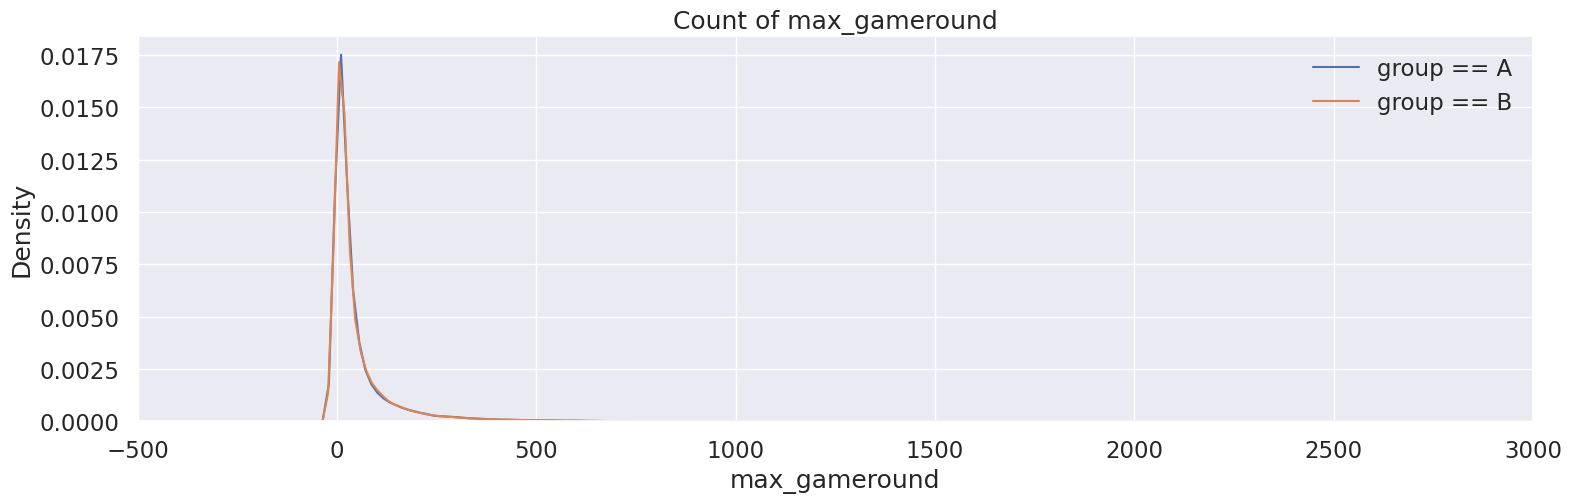

In [59]:
f, ax = plt.subplots(1, 1, figsize = (18, 5))

sns.kdeplot(df_all[ (df_all['group'] == 'A')]['max_gameround'], ax = ax )
sns.kdeplot(df_all[ (df_all['group'] == 'B')]['max_gameround'], ax = ax )

plt.xlim(-500, 3000)
plt.legend(['group == A', 'group == B'])
plt.title('Count of max_gameround')
plt.show()


1. Assumption 체크 

1) `Normality(Shapiro-Wilk Test)`
- 결과: 정규 분포를 따르지 않음 (A, B 모두) 

2) `Homogenity(Levene Test) `
- 이미 정규분포를 따르지 않으므로 해당 단계 스킵 

=> Non-parametric Test인 Mann Whitney U Test로 검정 진행 


---



2. 가설 검정 

*   H0: 두 그룹 간 유의미한 차이가 없다 
*   H1: 두 그룹 간 유의미한 차이가 있다 

**결과: p-value > 0.05이므로 H0 기각 실패**
**즉, A group과 B group의 결과가 비슷하다.**

하지만 p-value가 0.05xxx 였으므로... retention 변수를 더 살펴본다. 

## 3.2 Retention 

#_4. 결론 